In [1]:
# How can we get a clean dataset of COVID deaths in WI?
import geopandas as gpd
import os

if not os.path.exists("covid.geojson"):
    print("DOWNLOADING")
    url = "https://opendata.arcgis.com/datasets/559d482bad0643f69cbe1538243e0baa_9.geojson"
    df = gpd.read_file(url)
    df.to_file("covid.geojson", index=0)

df = gpd.read_file("covid.geojson")

In [2]:
df.columns

Index(['RptDt', 'GEOID', 'GEOName', 'POS_CUM_CP', 'POS_NEW_CP',
       'POS_7DAYAVG_CP', 'DTH_CUM_CP', 'DTH_NEW_CP', 'DTH_7DAYAVG_CP',
       'DTH_OVER_30DAYS_CP', 'DTH_CP_Daily', 'NEG_CUM', 'NEG_NEW',
       'NEG_7DAYAVG', 'TESTS_CUM', 'TESTS_NEW', 'TESTS_7DAYAVG',
       'POS_CUM_CONF', 'POS_NEW_CONF', 'POS_7DAYAVG_CONF', 'POS_CUM_PROB',
       'POS_NEW_PROB', 'POS_7DAYAVG_PROB', 'DTH_CUM_CONF', 'DTH_NEW_CONF',
       'DTH_7DAYAVG_CONF', 'DTH_CONF_Daily', 'DTH_CUM_PROB', 'DTH_NEW_PROB',
       'DTH_7DAYAVG_PROB', 'DTH_PROB_Daily', 'POS_MALE_CP', 'POS_FEM_CP',
       'POS_OTH_CP', 'POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP',
       'POS_30_39_CP', 'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP',
       'POS_70_79_CP', 'POS_80_89_CP', 'POS_90_CP', 'DTHS_FEM_CP',
       'DTHS_MALE_CP', 'DTHS_OTH_CP', 'DTHS_0_9_CP', 'DTHS_10_19_CP',
       'DTHS_20_29_CP', 'DTHS_30_39_CP', 'DTHS_40_49_CP', 'DTHS_50_59_CP',
       'DTHS_60_69_CP', 'DTHS_70_79_CP', 'DTHS_80_89_CP', 'DTHS_90_CP',
       'PO

In [3]:
# POP, POS_CUM_CP, POS_???_???_CP, DTH_CUM_CP

In [4]:
# cleaning
df = df[df["GEOID"].str.fullmatch(r"\d+")] # remove non tract data
df.replace(-999, 2, inplace=True) # -999 means 0-4 (hidden for privacy reasons)

<AxesSubplot:xlabel='POP', ylabel='DTH_CUM_CP'>

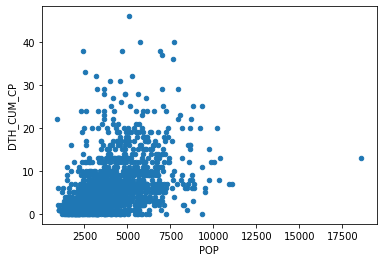

In [5]:
df.plot.scatter(x="POP", y="DTH_CUM_CP")

In [6]:
df.sort_values(by="DTH_CUM_CP", ascending=False).head()

,RptDt,GEOID,GEOName,POS_CUM_CP,POS_NEW_CP,POS_7DAYAVG_CP,DTH_CUM_CP,DTH_NEW_CP,DTH_7DAYAVG_CP,DTH_OVER_30DAYS_CP,...,HOSP_NO_CP,HOSP_UNK_CP,Date,POP,POP_MOE,OBJECTID,GEO,ShapeSTArea,ShapeSTLength,geometry
1372,2021-11-12T20:00:00+00:00,55135100600,None,930,5,2.86,46,0,0.0,0,...,459,419,2021-11-11T00:00:00+00:00,5071,238.0,3561,Census tract,3.632761e+08,100622.628105,"POLYGON ((-89.06994 44.33802, -89.07060 44.338..."
919,2021-11-12T20:00:00+00:00,55059000602,None,1267,5,2.29,40,0,0.0,0,...,478,703,2021-11-11T00:00:00+00:00,7708,532.0,2675,Census tract,1.468191e+07,18208.599197,"POLYGON ((-87.84582 42.63908, -87.84604 42.639..."
1385,2021-11-12T20:00:00+00:00,55133202202,None,1013,3,1.71,40,0,0.0,0,...,442,477,2021-11-11T00:00:00+00:00,5738,314.0,3602,Census tract,5.952951e+06,13537.586161,"POLYGON ((-88.23580 43.01317, -88.23587 43.013..."
68,2021-11-12T20:00:00+00:00,55101001502,None,1111,0,2.43,38,0,0.0,0,...,991,32,2021-11-11T00:00:00+00:00,6891,368.0,336,Census tract,2.466766e+07,24613.421935,"POLYGON ((-87.79587 42.80634, -87.79851 42.806..."
1356,2021-11-12T20:00:00+00:00,55133201402,None,716,4,3.14,38,0,0.0,0,...,301,358,2021-11-11T00:00:00+00:00,4709,434.0,3450,Census tract,9.929615e+06,13516.790357,"POLYGON ((-88.06726 43.01641, -88.06827 43.016..."


In [7]:
# How can we train/fit models to known data to predict unknowns?

# POP => DTH_CUM_CP

# sklearn expects something like a DataFrame for the features(x)
xcols = ["POP"]
df[xcols].head()

,POP
0,2243
1,5217
2,6787
3,3493
4,1463


In [8]:
# sklearn expects something like a Series for the label(y)
ycol = "DTH_CUM_CP"
df[ycol].head()

0     0
1     6
2    19
3     7
4     0
Name: DTH_CUM_CP, dtype: int64

In [9]:
import pandas as pd
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(df[xcols], df[ycol]) # fit means train

predict_df = pd.DataFrame({
    "POP": [1000, 2000]
})
predict_df["predict_death"] = model.predict(predict_df[xcols]) # what y values are estimated
predict_df

,POP,predict_death
0,1000,2.525213
1,2000,3.867524


In [19]:
# How can we visualize model predictions?
predict_df = pd.DataFrame({
    "POP": range(0, 20000, 1000)
})
predict_df["predict_death"] = model.predict(predict_df[xcols]) # what y values are estimated
predict_df.head()

,POP,predict_death
0,0,1.182903
1,1000,2.525213
2,2000,3.867524
3,3000,5.209834
4,4000,6.552145


<AxesSubplot:xlabel='POP', ylabel='DTH_CUM_CP'>

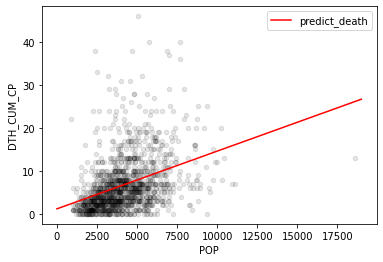

In [11]:
ax = predict_df.plot.line(x="POP", y="predict_death", color="red")
df.plot.scatter(x="POP", y="DTH_CUM_CP", ax=ax, color="black", alpha=0.1)

In [21]:
# How can we get a formula for the relationship?
slope = model.coef_[0]
slope

0.0013423105598069026

In [22]:
model.intercept_

1.1829028125539898

In [23]:
f"deaths = {slope} * population + {model.intercept_}"

'deaths = 0.0013423105598069026 * population + 1.1829028125539898'

In [13]:
# How well does our model fit the data?
#r2_score

In [25]:
before = df[ycol].var()
before

39.239011357908396

In [34]:
residuals = df[ycol] - model.predict(df[xcols])
after = residuals.var()
after

33.743878062863864

In [35]:
improvement = before - after
improvement

5.495133295044532

In [36]:
improvement / before # r^2 score, "explained variance"

0.14004260313599923

In [37]:
model.score(df[xcols], df[ycol])

0.14004260313599926

In [58]:
# Did our model learn or memorize (that is, "overfit")?
from sklearn.model_selection import train_test_split, cross_val_score

#train = df.iloc[:len(df)//2]
#test = df.iloc[len(df)//2:]

train, test = train_test_split(df) # random each time
print(len(train), len(test))

model.fit(train[xcols], train[ycol])
model.score(test[xcols], test[ycol])

1044 348


0.07556305249213169

In [60]:
# How can we minimize noise due to random train/test splits?

# loop 5 times, each time creating a different train/test split
# for each, fit the training, score the test data
scores = cross_val_score(model, train[xcols], train[ycol])
scores

array([0.05965855, 0.14095434, 0.17265263, 0.17053815, 0.15782394])

In [64]:
scores.mean(), scores.std() # average and standard deviation

(0.1403255205494895, 0.041884591397839)

In [68]:
# How can we compare models?
xcols2 = ["POS_CUM_CP"]
ycol2 = "DTH_CUM_CP"
model2 = LinearRegression()
scores2 = cross_val_score(model2, train[xcols2], train[ycol2])
scores2

array([0.12089724, 0.18827916, 0.15356653, 0.26029948, 0.23843755])

In [69]:
scores2.mean(), scores2.std()

(0.19229599147692622, 0.0517057168437673)

Text(0, 0.5, 'Explained Variance (Deaths)')

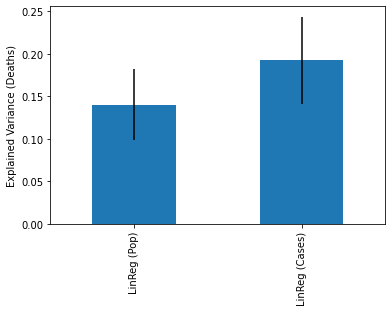

In [77]:
# want a plot with a bar for each model score
compare = pd.DataFrame({
    "scores": {"LinReg (Pop)": scores.mean(), "LinReg (Cases)": scores2.mean()},
    "std_dev": {"LinReg (Pop)": scores.std(), "LinReg (Cases)": scores2.std()}
})

ax = compare["scores"].plot.bar(yerr=compare["std_dev"])
ax.set_ylabel("Explained Variance (Deaths)")

In [83]:
# How can we use multiple x variables (multiple regression)?
# How can we compare models?
xcols3 = ['POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP',
       'POS_30_39_CP', 'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP',
       'POS_70_79_CP', 'POS_80_89_CP', 'POS_90_CP']
ycol3 = "DTH_CUM_CP"
model3 = LinearRegression()
scores3 = cross_val_score(model3, train[xcols3], train[ycol3])
scores3

array([0.63813558, 0.7366139 , 0.60104587, 0.59066982, 0.72758123])

In [87]:
scores3.mean()

0.658809281259141

In [89]:
# How can we interpret what features the model is relying on?
model3.fit(train[xcols3], train[ycol3])
model3.coef_

array([-0.014016  , -0.00288481,  0.00137366,  0.0168661 ,  0.01338689,
       -0.0174848 ,  0.00179548,  0.02708337,  0.18474261,  0.34624869])

<AxesSubplot:>

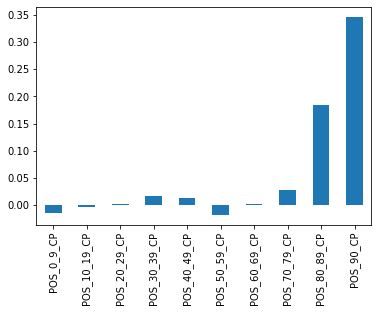

In [91]:
pd.Series(model3.coef_, index=xcols3).plot.bar()